In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
from helpers import calculate_metric, combine_folds, create_pivot_tables
from matplotlib import pyplot as plt

from neuralhydrology.evaluation import metrics
from neuralhydrology.utils.nh_results_ensemble  import _get_results_file
from neuralhydrology.nh_run_data_dir import cached_eval_run

In [48]:
base_path = Path('/Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs')

static_attributes = [
    '',
    'Are',  # Catchment Area
    'Pme',  # Precipitation Mean
    'Pet',  # PET Mean
    # 'Run',  # Runoff Ratio
    # 'Slo',  # Slope FDC
    'Str',  # Stream Elasticity
    'Bas',  # Baseflow Index
    'Hpf',  # High Precipitation Frequency
    'Hpd',  # High Precipitation Duration
    # 'Lpf',  # Low Precipitation Frequency
    'Lpd',  # Low Precipitation Duration
    # 'Mea',  # Mean Slope Percentage
    # ##'Ksa',  # Saturation Hydraulic Conductivity (Ksat) Not producd correctly
    # 'Ari',  # Aridity Index
    # 'Pse',  # Precipitation Seasonality Index
]

static_attributes = ['']

dynamic_predictors = ['Pra',
              'PraEts',
              'Prs',
              'PrsEts',
              'PrsEas',
              ]

run_list = [
    {'dir': base_path/('temporal_twofold_{fold:d}'+f'_PraEts_{sa}_0602_??????'), 'dim_name':'temporal'} for sa in static_attributes
]

run_list += [
    {'dir': base_path/('temporal_twofold_{fold:d}'+f'_PraEts_{sa}_0502_??????'), 'dim_name':'temporal'} for sa in static_attributes
]

run_list += [
    {'dir': base_path/('spatial_twofold_{fold:d}'+f'_PraEts_{sa}_????_12????'), 'dim_name':'spatial'} for sa in static_attributes
]


run_list


[{'dir': PosixPath('/Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/temporal_twofold_{fold:d}_PraEts__0602_??????'),
  'dim_name': 'temporal'},
 {'dir': PosixPath('/Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/temporal_twofold_{fold:d}_PraEts__0502_??????'),
  'dim_name': 'temporal'},
 {'dir': PosixPath('/Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/spatial_twofold_{fold:d}_PraEts__????_12????'),
  'dim_name': 'spatial'}]

In [49]:
from pathlib import Path
from glob import glob

def get_dir(s: str) -> list[Path]:
    """
    Get the directory paths based on the provided glob pattern.

    Parameters:
    - s (str): The glob pattern for the directory.

    Returns:
    - list[Path]: A list of Path objects representing the directories found.

    Raises:
    - ValueError: If no matching directory is found.
    """
    dir_list = [Path(x) for x in glob(s)]
    if dir_list:
        return dir_list
    else:
        raise ValueError(f"No matching directory found for the given pattern: '{s}'.")

def get_unique_dir(s: str) -> Path:
    """
    Get the unique directory path based on the provided glob pattern.

    Parameters:
    - s (str): The glob pattern for the directory.

    Returns:
    - Path: The Path object representing the unique directory.

    Raises:
    - ValueError: If multiple matching directories are found or no matching directory is found.
    """
    dir_list = get_dir(s)
    if len(dir_list) == 1:
        return dir_list[0]
    elif len(dir_list) > 1:
        dir_paths = '\n'.join(str(path) for path in dir_list)
        raise ValueError(f"Multiple matching directories found for the given pattern: '{s}':\n{dir_paths}")
    else:
        raise ValueError(f"No matching directory found for the given pattern: '{s}'.")


In [50]:
import pickle
metric_df_list = []
for run in run_list:
    results = {}
    for fold in (0, 1):
        run_dir = get_unique_dir(str(run['dir']).format(fold=fold))

        #results[fold] = cached_eval_run(run_dir=run_dir, period='test')
        run= _get_results_file(run_dir)
        results[fold] = pickle.load(open(run, 'rb'))

         
        df = combine_folds(results, dim_name=run['dim_name'])
        sim, obs = create_pivot_tables(df)
        metric_df = calculate_metric(sim, obs, metrics.nse, name=run['dir'].name)
    metric_df_list.append(metric_df)

all_metrics_df = pd.concat(metric_df_list, axis=1)

# sort them based on the means:
all_metrics_df[all_metrics_df.mean().sort_values(ascending=False).keys()]

Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/temporal_twofold_0_PraEts__0602_120547/postprocess/test_cached_data.pkl
Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/temporal_twofold_1_PraEts__0602_120547/postprocess/test_cached_data.pkl
Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/temporal_twofold_0_PraEts__0502_150900/postprocess/test_cached_data.pkl
Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/temporal_twofold_1_PraEts__0502_150900/postprocess/test_cached_data.pkl
Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/spatial_twofold_0_PraEts__0602_120547/postprocess/test_cached_data.pkl
Loading cached data for test from /Users/sho108/Desktop/r/work/sho108/neuralhydrology_workflow/runs/spatial_twofold_1_PraEts__0602_120547/pos

,temporal_twofold_{fold:d}_PraEts__0602_??????,spatial_twofold_{fold:d}_PraEts__????_12????,temporal_twofold_{fold:d}_PraEts__0502_??????
102101A,-0.573126,-0.723587,-0.938105
104001A,0.387106,0.218697,0.285091
105101A,0.445413,0.467158,0.464254
105102A,-0.373649,-0.785030,-0.815897
105105A,0.687414,0.694326,0.715091
...,...,...,...
G8200045,-0.069612,0.004437,-0.484762
G8210010,-0.410350,-0.528850,-0.766120
G9030124,0.350483,0.351261,0.101359
G9030250,0.463703,0.436549,0.414185


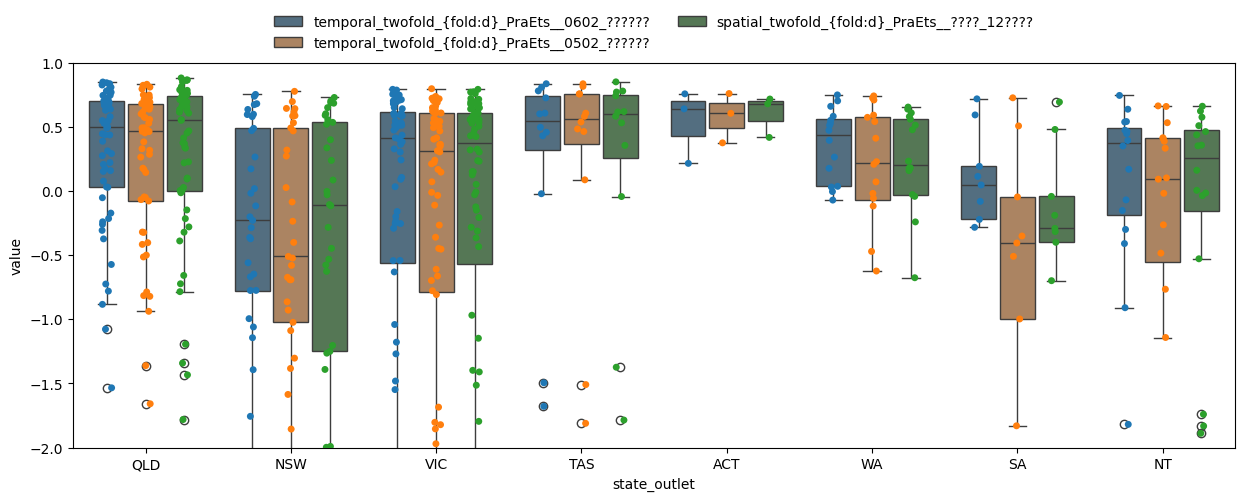

In [74]:
# Load attribute data
attr_df = pd.read_csv('/Users/sho108/Desktop/z/Data/CAMELS_AUS/CAMELS_AUS_Attributes&Indices_MasterTable.csv', index_col=0)

# Combine metric and attribute data
data = pd.concat([all_metrics_df, attr_df], axis=1).reset_index()

# Melt the data for better visualization
data_melted = data.melt(value_vars=all_metrics_df.columns, id_vars=['drainage_division', 'river_region', 'state_outlet'])

# Set up the plotting environment
plt.figure(figsize=(15, 5))

# Specify the variable for x-axis
x = 'state_outlet'

# Create a boxplot and stripplot using seaborn
hue_order = None# all_metrics_df.median().sort_values(ascending=False).keys()
ax = sns.boxplot(data_melted, y='value', x=x, hue='variable', hue_order=hue_order, saturation=0.3, gap=0.1)
sns.stripplot(data=data_melted, y='value', x=x, hue='variable', dodge=True, ax=ax, legend=False)

# Set y-axis limits
plt.ylim(-2, 1)

# Move legend to a more suitable position
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False)

# Show the plot
plt.show()


Text(0, 0.5, 'nse')

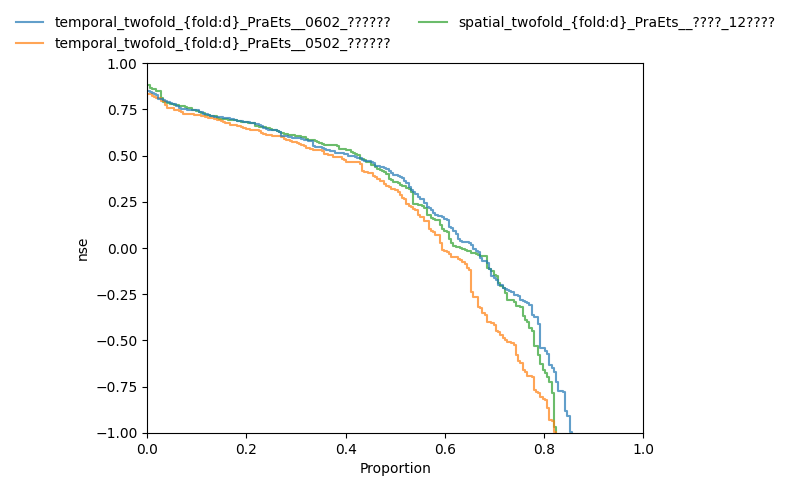

In [52]:
#value_vars = all_metrics_df.columns
#data_melted = data.melt(value_vars=value_vars, id_vars=['drainage_division', 'river_region', 'state_outlet'])

x = 'state_outlet'
ax = sns.ecdfplot(data_melted , y='value', hue='variable', hue_order=hue_order, complementary=True, alpha=0.7)
ax.set_ylim(-1,1)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,)
plt.ylabel('nse')